In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from pylab import rcParams
from keras import regularizers
from keras.layers import Input, Dense
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import precision_recall_fscore_support

# Dataload&Preprocessing

In [2]:
df=pd.read_csv('../dataset/WISDM.csv', index_col=0)
df = df.drop(columns=['user-id', 'timestamp'])

df

,activity,X,Y,Z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
1098199,Sitting,9.000000,-1.570000,1.690000
1098200,Sitting,9.040000,-1.460000,1.730000
1098201,Sitting,9.080000,-1.380000,1.690000
1098202,Sitting,9.000000,-1.460000,1.730000


# Jogging&Sitting 제외 모두 drop

In [3]:
activities = df['activity'].unique() # activity 열의 고유한 값 확인

print(activities) # 고유한 활동 출력

['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']


In [4]:
# 'Jogging'과 'Sitting'을 제외한 나머지 활동을 삭제
df = df[df['activity'].isin(['Jogging', 'Sitting'])]

df

,activity,X,Y,Z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
1098199,Sitting,9.000000,-1.570000,1.690000
1098200,Sitting,9.040000,-1.460000,1.730000
1098201,Sitting,9.080000,-1.380000,1.690000
1098202,Sitting,9.000000,-1.460000,1.730000


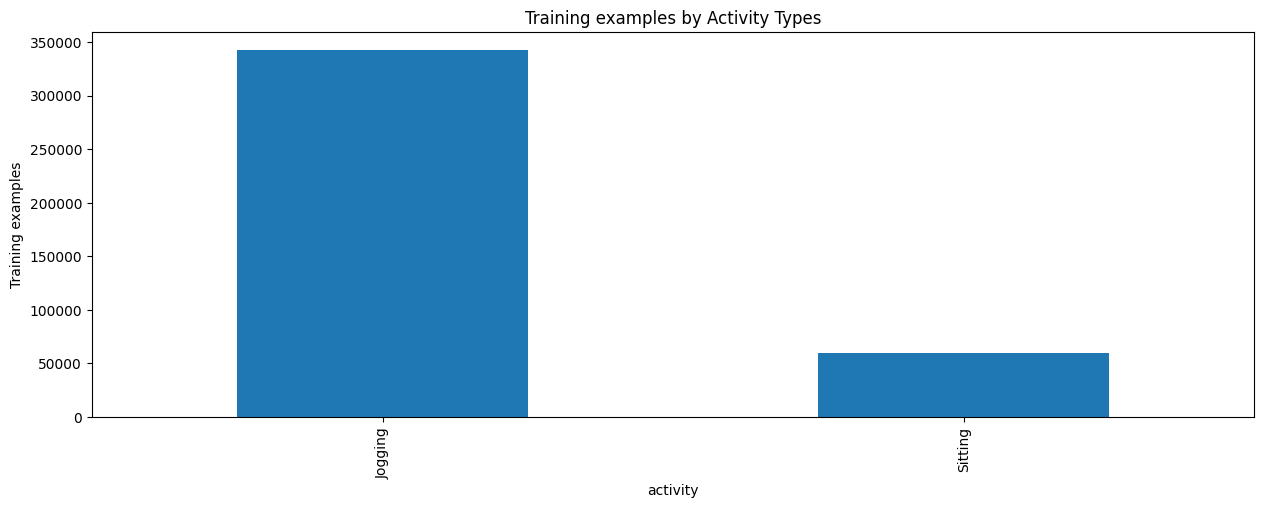

In [5]:
# 첫 번째 그래프: Activity Type에 따른 훈련 예제 수를 막대 그래프로 표시
plt.figure(figsize=(15, 5))  # 그래프의 크기를 설정
plt.xlabel('Activity Type')  # x 축 레이블 설정
plt.ylabel('Training examples')  # y 축 레이블 설정
df['activity'].value_counts().plot(kind='bar',  # 'activity' 열의 값 수를 막대 그래프로 표시
                                  title='Training examples by Activity Types')  # 그래프 제목 설정
plt.show()  # 그래프를 화면에 표시

# Jogging&Sitting selection(4500)

In [6]:
# 'Jogging'과 'Sitting'을 각각 4500개씩만 선택
Jogging = df[df['activity'] == 'Jogging'].head(4499).copy()
Sitting = df[df['activity'] == 'Sitting'].head(4500).copy()

# Data balancing

In [7]:
balanced_data = pd.DataFrame()
balanced_data = pd.concat([balanced_data, Jogging, Sitting]) # concat(): 두 DF을 합쳐 새 DF를 생성.

balanced_data.shape

(8999, 4)

In [8]:
balanced_data

,activity,X,Y,Z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
255294,Sitting,-4.330000,-2.180000,8.308413
255295,Sitting,-4.370000,-2.220000,8.349273
255296,Sitting,-4.290000,-2.220000,8.308413
255297,Sitting,-4.290000,-2.220000,8.281172


In [9]:
balanced_data['activity'].value_counts()

activity
Sitting    4500
Jogging    4499
Name: count, dtype: int64

# LabelEncoding

In [10]:
le=LabelEncoder()

# label인코딩으로 activity의 범주형data를 숫자로 변환
balanced_data['activity']=le.fit_transform(balanced_data['activity']) # fit_transform메서드: data에 대한 변환 규칙 학습, 이를 기반으로 data 변환.

# Train/Test split

In [11]:
X_train, X_test = train_test_split(balanced_data, train_size=0.75, random_state=42)
X_train.shape, X_test.shape

((6749, 4), (2250, 4))

In [23]:
X_train = X_train[X_train['activity']==0]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3399 entries, 7410 to 5824
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   activity  3399 non-null   int32  
 1   X         3399 non-null   float64
 2   Y         3399 non-null   float64
 3   Z         3399 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 119.5 KB


In [25]:
x_train = X_train.drop(['activity'], axis=1)
x_train

,X,Y,Z
7410,3.868179,2.724070,1.757025
6997,4.399372,11.223166,-4.562817
12690,5.325556,14.287745,-1.879608
7363,5.134871,15.636159,-7.205164
51,-0.081722,11.917805,-7.886181
...,...,...,...
5733,-9.615966,9.888372,3.445948
7228,-3.759216,7.246025,6.469665
12946,5.706926,3.827318,-0.190685
466,-11.304889,8.076866,4.058864


# Noise

In [32]:
noise_factor = 0.50

x_train_noisy = x_train.copy() + noise_factor * \
np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)

x_test_noisy = X_test.copy() + noise_factor * \
np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

In [33]:
input_dim = x_train.shape[1]
encoding_dim = 20
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim/2, activation="relu", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim/2 ), activation='relu')(encoder)
encoder = Dense(int(encoding_dim/4 ), activation='relu')(encoder)
encoder = Dense(int(encoding_dim / 6), activation='linear')(encoder)
decoder = Dense(int(encoding_dim/4 ), activation='relu')(encoder)
decoder = Dense(int(encoding_dim/2 ), activation='relu')(decoder)
decoder = Dense(int(encoding_dim/2 ), activation='relu')(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [34]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_4 (Dense)             (None, 10)                40        
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 5)                 55        
                                                                 
 dense_7 (Dense)             (None, 3)                 18        
                                                                 
 dense_8 (Dense)             (None, 5)                 20        
                                                                 
 dense_9 (Dense)             (None, 10)                60  

In [36]:
#nb_epoch = 100
nb_epoch = 20
batch_size = 16
autoencoder.compile(optimizer='Adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='/logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train_noisy,x_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data = (x_train_noisy, x_train),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/20
213/213 [==============================] - 2s 3ms/step - loss: 21.2897 - accuracy: 0.7773 - val_loss: 14.6151 - val_accuracy: 0.8099
Epoch 2/20
213/213 [==============================] - 1s 3ms/step - loss: 10.3377 - accuracy: 0.8305 - val_loss: 7.5818 - val_accuracy: 0.8488
Epoch 3/20
213/213 [==============================] - 1s 2ms/step - loss: 6.3942 - accuracy: 0.8673 - val_loss: 5.6621 - val_accuracy: 0.8803
Epoch 4/20
213/213 [==============================] - 0s 2ms/step - loss: 5.2145 - accuracy: 0.8817 - val_loss: 4.2654 - val_accuracy: 0.8811
Epoch 5/20
213/213 [==============================] - 0s 2ms/step - loss: 2.3955 - accuracy: 0.8832 - val_loss: 1.5149 - val_accuracy: 0.8964
Epoch 6/20
213/213 [==============================] - 0s 2ms/step - loss: 1.3199 - accuracy: 0.9011 - val_loss: 1.2009 - val_accuracy: 0.9014
Epoch 7/20
213/213 [==============================] - 0s 2ms/step - loss: 1.1233 - accuracy: 0.9100 - val_loss: 1.0266 - val_accuracy: 0.9156
Epo

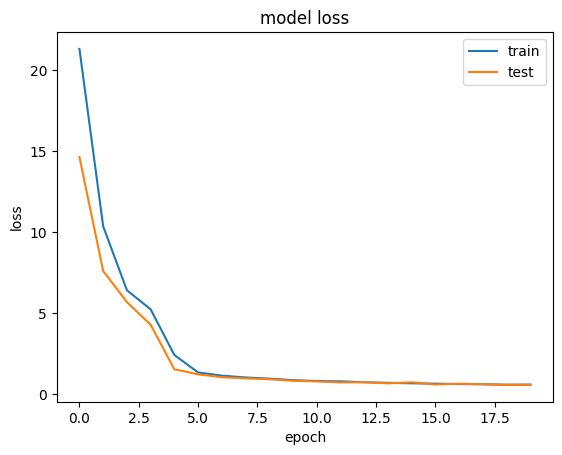

In [37]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [39]:
predictions = autoencoder.predict(x_test_noisy)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

71/71 [==============================] - 0s 941us/step


,reconstruction_error,true_class
count,2250.000000,2250.000000
mean,4.500636,0.511111
std,6.862679,0.499988
min,0.002030,0.000000
25%,0.173935,0.000000
50%,0.414918,1.000000
75%,14.009166,1.000000
max,67.325278,1.000000


In [41]:
error_df.true_class.value_counts()

true_class
1    1150
0    1100
Name: count, dtype: int64

In [42]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

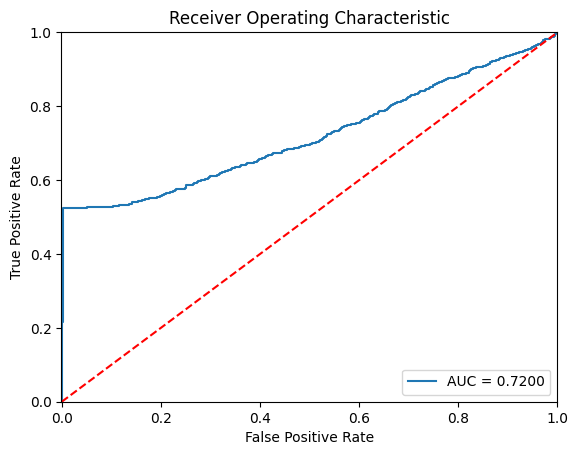

In [43]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

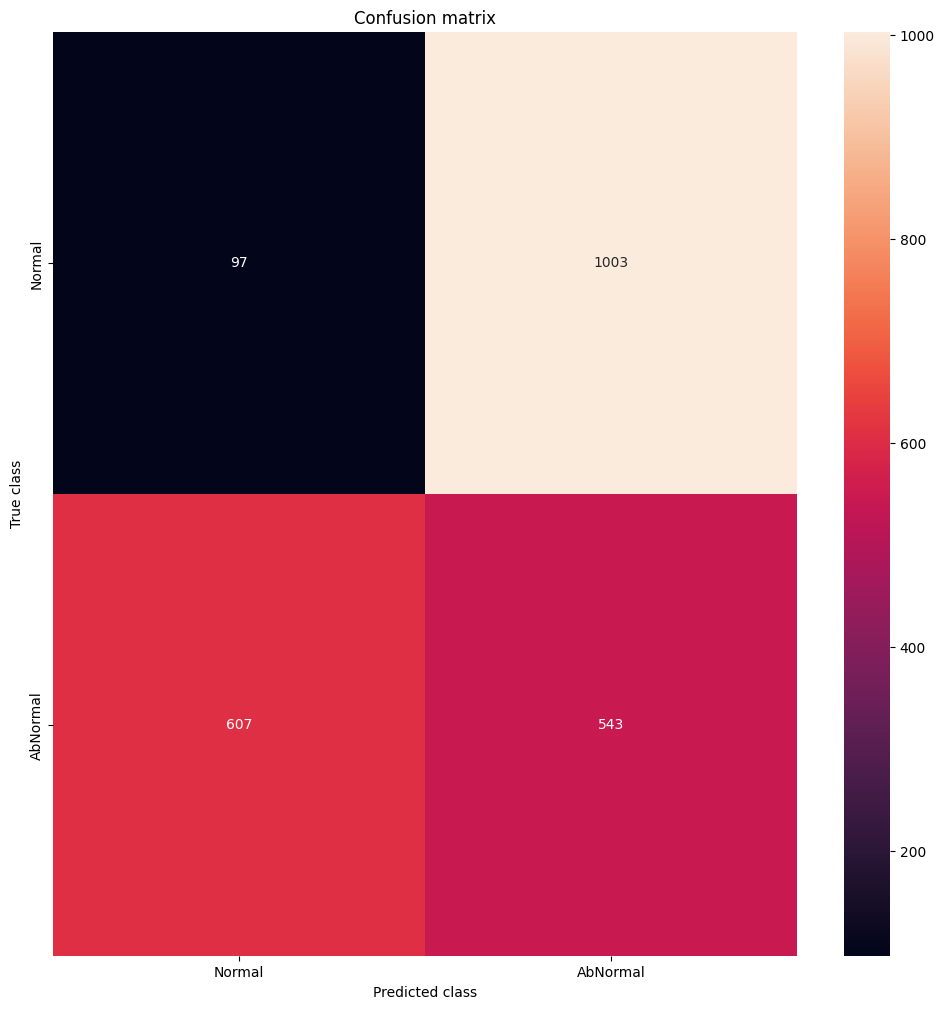

In [49]:
#평가관련
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

LABELS = ["Normal", "AbNormal"]
threshold = 1


y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

plt.title("Confusion matrix")

plt.ylabel('True class')

plt.xlabel('Predicted class')

plt.show()

In [50]:
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')

print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )

print ('Precision :',precision )

print ('Recall :',recall )

print ('F1 :',f1 )

Accuracy Score : 0.28444444444444444
Precision : 0.351228978007762
Recall : 0.4721739130434783
F1 : 0.40281899109792285


# 재구성 오차(Reconstruction error) 기반, 이상 감지 모델 결과 시각화

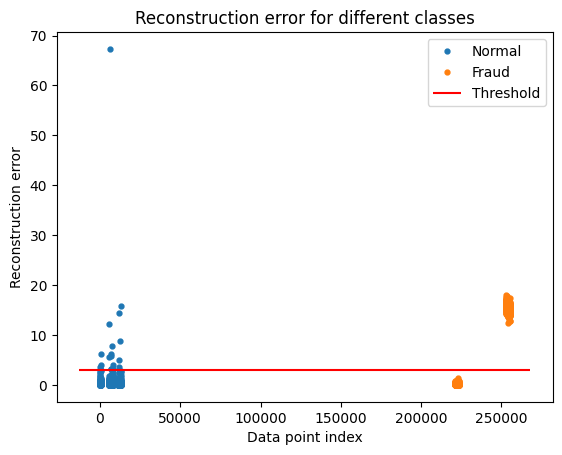

In [45]:
threshold = 3 # 임계값(Threshold 설정)

groups = error_df.groupby('true_class') # True_class에 따른 data group화

fig, ax = plt.subplots() # Graph 생성

# 각 Group에 대한 재구성 오차 플로팅
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
# 임계값을 Red line으로 설정
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

# Graph title & Label 설정
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();